In [67]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (precision_score,
                             recall_score,
                             accuracy_score,
                             f1_score,
                             confusion_matrix,
                             plot_confusion_matrix)
from xgboost import XGBClassifier



In [24]:
X_train_res = pd.read_pickle("../data/X_train_res.pkl")
y_train_res = pd.read_pickle("../data/y_train_res.pkl")

X_train = pd.read_pickle("../data/X_train.pkl")
y_train = pd.read_pickle("../data/y_train.pkl")

X_test = pd.read_pickle("../data/X_test.pkl")
y_test = pd.read_pickle("../data/y_test.pkl")

In [29]:
for feature in X_train.columns:
    if X_train[feature].dtype not in ["int", "float"]:
        for df in [X_train, X_train_res, X_test]:
            df[feature] = df[feature].cat.codes

## priority = overall accuracy

In [58]:
param_grid_res = {
"n_estimators"      : [10, 30 , 100, 300, 1000, 1300, 3000],
 "max_depth"        : [2,3,10, 13, 20, 23],
 "learning_rate"    : [ 0.1, 0.03, 0.01, 0.003],
 "reg_lambda"       : [10,50,100],
 "gamma"            : [0.25,1.0,10]
             }

param_grid_norm = param_grid_res
param_grid_norm["scale_pos_weight"] = [4.86]

# define evaluation procedure
norm_search = GridSearchCV(estimator=xgbmodel,
                           param_grid=param_grid_norm,
                           n_jobs=-1,
                           scoring='roc_auc').fit(X_train,y_train)

res_search = GridSearchCV(estimator=xgbmodel,
                          param_grid=param_grid_res,
                          n_jobs=-1,
                          scoring='roc_auc').fit(X_train_res,y_train_res)


In [72]:
norm_search.best_params_

{'gamma': 0.25,
 'learning_rate': 0.01,
 'max_depth': 2,
 'n_estimators': 10,
 'reg_lambda': 50,
 'scale_pos_weight': 4.86}

In [71]:
res_search.best_params_

{'gamma': 0.25,
 'learning_rate': 0.01,
 'max_depth': 10,
 'n_estimators': 3000,
 'reg_lambda': 10,
 'scale_pos_weight': 4.86}

Accuracy Train:  0.682, Accuracy Test: 0.631
Recall Train:  0.678, Recall Test: 0.522
Precision Train:  0.226, Precision Test: 0.226
[[77 41]
 [11 12]]


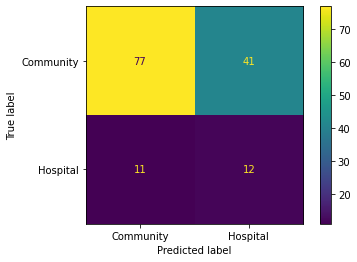

In [69]:
n_train_pred = (norm_search.predict(X_train)).reshape(-1,1)
n_test_pred = (norm_search.predict(X_test)).reshape(-1,1)
accuracy_train = accuracy_score(n_train_pred,y_train)
accuracy_test = accuracy_score(n_test_pred,y_test)
recall_train = recall_score(y_train,n_train_pred)
recall_test = recall_score(y_test,n_test_pred)
precision_train = precision_score(y_test,n_test_pred)
precision_test = precision_score(y_test,n_test_pred)
print('Accuracy Train:  %.3f, Accuracy Test: %.3f' %  (accuracy_train,accuracy_test))
print('Recall Train:  %.3f, Recall Test: %.3f' %  (recall_train,recall_test))
print('Precision Train:  %.3f, Precision Test: %.3f' %  (precision_train,precision_test))
print(confusion_matrix(y_test,n_test_pred))

plot_confusion_matrix(norm_search,X_test,y_test,display_labels=['Community','Hospital'])

Accuracy Train:  1.000, Accuracy Test: 0.730
Recall Train:  1.000, Recall Test: 0.348
Precision Train:  0.258, Precision Test: 0.258
[[95 23]
 [15  8]]


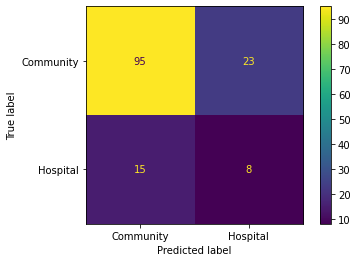

In [70]:
r_train_pred = (res_search.predict(X_train_res)).reshape(-1,1)
r_test_pred = (res_search.predict(X_test)).reshape(-1,1)
accuracy_train = accuracy_score(r_train_pred,y_train_res)
accuracy_test = accuracy_score(r_test_pred,y_test)
recall_train = recall_score(y_train_res, r_train_pred)
recall_test = recall_score(y_test, r_test_pred)
precision_train = precision_score(y_test, r_test_pred)
precision_test = precision_score(y_test, r_test_pred)
print('Accuracy Train:  %.3f, Accuracy Test: %.3f' %  (accuracy_train,accuracy_test))
print('Recall Train:  %.3f, Recall Test: %.3f' %  (recall_train,recall_test))
print('Precision Train:  %.3f, Precision Test: %.3f' %  (precision_train,precision_test))
print(confusion_matrix(y_test,r_test_pred))

plot_confusion_matrix(res_search, X_test, y_test, display_labels=['Community','Hospital'])

## priority = recall

In [74]:
param_grid_res = {
"n_estimators"      : [10, 30 , 100, 300, 1000, 1300, 3000],
 "max_depth"        : [2,3,10, 13, 20, 23],
 "learning_rate"    : [ 0.1, 0.03, 0.01, 0.003],
 "reg_lambda"       : [10,50,100],
 "gamma"            : [0.25,1.0,10]
             }

param_grid_norm = param_grid_res
param_grid_norm["scale_pos_weight"] = [4.86]

# define evaluation procedure
norm_search = GridSearchCV(estimator=xgbmodel,
                           param_grid=param_grid_norm,
                           n_jobs=-1,
                           scoring='recall').fit(X_train,y_train)

res_search = GridSearchCV(estimator=xgbmodel,
                          param_grid=param_grid_res,
                          n_jobs=-1,
                          scoring='recall').fit(X_train_res,y_train_res)


In [75]:
norm_search.best_params_

{'gamma': 0.25,
 'learning_rate': 0.03,
 'max_depth': 2,
 'n_estimators': 10,
 'reg_lambda': 50,
 'scale_pos_weight': 4.86}

In [76]:
res_search.best_params_

{'gamma': 0.25,
 'learning_rate': 0.1,
 'max_depth': 2,
 'n_estimators': 30,
 'reg_lambda': 100,
 'scale_pos_weight': 4.86}

Accuracy Train:  0.682, Accuracy Test: 0.631
Recall Train:  0.678, Recall Test: 0.522
Precision Train:  0.226, Precision Test: 0.226
[[77 41]
 [11 12]]


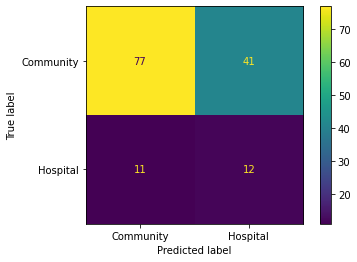

In [77]:
n_train_pred = (norm_search.predict(X_train)).reshape(-1,1)
n_test_pred = (norm_search.predict(X_test)).reshape(-1,1)
accuracy_train = accuracy_score(n_train_pred,y_train)
accuracy_test = accuracy_score(n_test_pred,y_test)
recall_train = recall_score(y_train,n_train_pred)
recall_test = recall_score(y_test,n_test_pred)
precision_train = precision_score(y_test,n_test_pred)
precision_test = precision_score(y_test,n_test_pred)
print('Accuracy Train:  %.3f, Accuracy Test: %.3f' %  (accuracy_train,accuracy_test))
print('Recall Train:  %.3f, Recall Test: %.3f' %  (recall_train,recall_test))
print('Precision Train:  %.3f, Precision Test: %.3f' %  (precision_train,precision_test))
print(confusion_matrix(y_test,n_test_pred))

plot_confusion_matrix(norm_search,X_test,y_test,display_labels=['Community','Hospital'])

Accuracy Train:  0.643, Accuracy Test: 0.404
Recall Train:  0.983, Recall Test: 0.826
Precision Train:  0.192, Precision Test: 0.192
[[38 80]
 [ 4 19]]


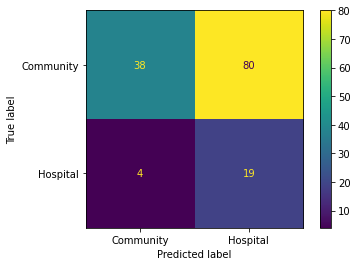

In [78]:
r_train_pred = (res_search.predict(X_train_res)).reshape(-1,1)
r_test_pred = (res_search.predict(X_test)).reshape(-1,1)
accuracy_train = accuracy_score(r_train_pred,y_train_res)
accuracy_test = accuracy_score(r_test_pred,y_test)
recall_train = recall_score(y_train_res, r_train_pred)
recall_test = recall_score(y_test, r_test_pred)
precision_train = precision_score(y_test, r_test_pred)
precision_test = precision_score(y_test, r_test_pred)
print('Accuracy Train:  %.3f, Accuracy Test: %.3f' %  (accuracy_train,accuracy_test))
print('Recall Train:  %.3f, Recall Test: %.3f' %  (recall_train,recall_test))
print('Precision Train:  %.3f, Precision Test: %.3f' %  (precision_train,precision_test))
print(confusion_matrix(y_test,r_test_pred))

plot_confusion_matrix(res_search, X_test, y_test, display_labels=['Community','Hospital'])